In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
cd /content/drive/My Drive/COVID/kaggledataset

/content/drive/My Drive/COVID/kaggledataset


In [11]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas.util.testing as tm

import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical


In [12]:
#define size to which images are to be resized
IMAGE_SIZE = [224, 224] # feel free to change depending on dataset

# training config:
epochs = 500
batch_size = 32

#define paths
covid_path = '/content/drive/My Drive/COVID/kaggledataset/COVID'
noncovid_path = '/content/drive/My Drive/COVID/kaggledataset/non-COVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [13]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_files[0:5])
print("Total Count: ",len(covid_files))
print("First 5 NonCovid Files: ",noncovid_files[0:5])
print("Total Count: ",len(noncovid_files))

First 5 Covid Files:  ['/content/drive/My Drive/COVID/kaggledataset/COVID/Covid (1244).png', '/content/drive/My Drive/COVID/kaggledataset/COVID/Covid (128).png', '/content/drive/My Drive/COVID/kaggledataset/COVID/Covid (1219).png', '/content/drive/My Drive/COVID/kaggledataset/COVID/Covid (1229).png', '/content/drive/My Drive/COVID/kaggledataset/COVID/Covid (1202).png']
Total Count:  1252
First 5 NonCovid Files:  ['/content/drive/My Drive/COVID/kaggledataset/non-COVID/Non-Covid (1185).png', '/content/drive/My Drive/COVID/kaggledataset/non-COVID/Non-Covid (1211).png', '/content/drive/My Drive/COVID/kaggledataset/non-COVID/Non-Covid (1226).png', '/content/drive/My Drive/COVID/kaggledataset/non-COVID/Non-Covid (117).png', '/content/drive/My Drive/COVID/kaggledataset/non-COVID/Non-Covid (1170).png']
Total Count:  1229


In [14]:
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per kera
  image = cv2.resize(image,(224,224)) # resize as per model
  covid_images.append(image) # append image
  covid_labels.append('CT_COVID') # append class label
for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  noncovid_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

In [15]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [16]:
# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [17]:
m = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

outputs = m.output
outputs= AveragePooling2D((2,2),strides=(2,2))(outputs)
outputs = Flatten(name="flatten")(outputs)
outputs = Dense(128, activation="relu")(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(64, activation="relu")(outputs)
outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=m.input, outputs=outputs)

for layer in m.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

58892288/58889256 [==============================] - 1s 0us/step


In [18]:
# Visualize Model
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [19]:
history = model.fit(X_train, y_train, batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / batch_size,
                    steps_per_epoch=len(X_train) / batch_size,
                    epochs=epochs)

Epoch 1/500
62/62 [==============================] - 6s 92ms/step - loss: 0.5634 - accuracy: 0.7056 - val_loss: 0.3821 - val_accuracy: 0.8531
Epoch 2/500
62/62 [==============================] - 5s 79ms/step - loss: 0.3533 - accuracy: 0.8503 - val_loss: 0.2754 - val_accuracy: 0.8913
Epoch 3/500
62/62 [==============================] - 5s 79ms/step - loss: 0.2507 - accuracy: 0.9012 - val_loss: 0.2148 - val_accuracy: 0.9195
Epoch 4/500
62/62 [==============================] - 5s 79ms/step - loss: 0.1995 - accuracy: 0.9189 - val_loss: 0.1964 - val_accuracy: 0.9235
Epoch 5/500
62/62 [==============================] - 5s 79ms/step - loss: 0.1575 - accuracy: 0.9461 - val_loss: 0.2051 - val_accuracy: 0.9115
Epoch 6/500
62/62 [==============================] - 5s 79ms/step - loss: 0.1574 - accuracy: 0.9385 - val_loss: 0.3072 - val_accuracy: 0.8612
Epoch 7/500
62/62 [==============================] - 5s 79ms/step - loss: 0.1621 - accuracy: 0.9370 - val_loss: 0.1332 - val_accuracy: 0.9416
Epoch 

In [20]:
# Save Model and Weights
model.save('VGG16.h5')
model.save_weights('VGG16_weights.hdf5')

In [21]:
# Load saved model
model = load_model('VGG16.h5')

In [22]:
y_pred = model.predict(X_test, batch_size=batch_size)

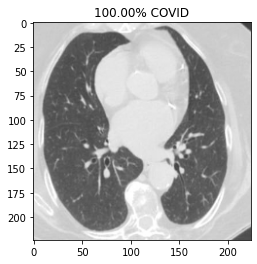

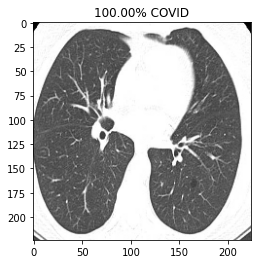

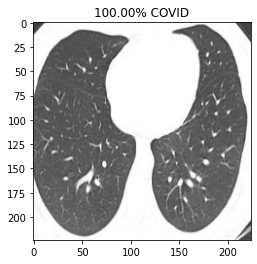

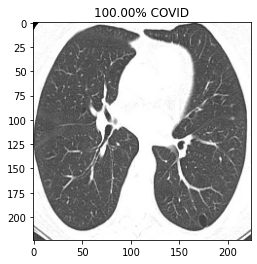

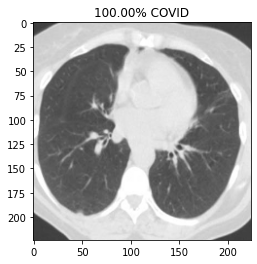

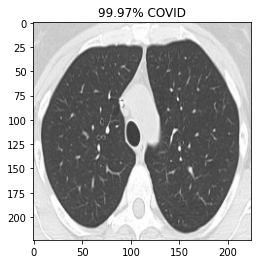

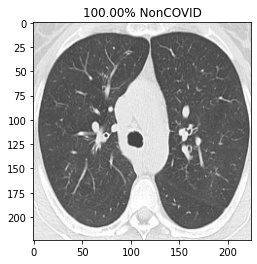

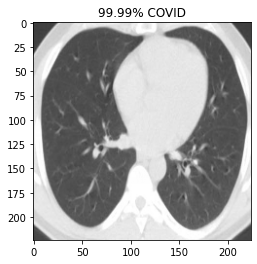

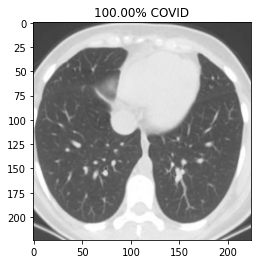

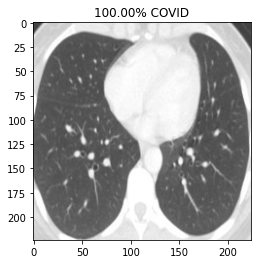

In [23]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.style.reload_library
  plt.imshow(X_test[index])
  plt.show()

In [24]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

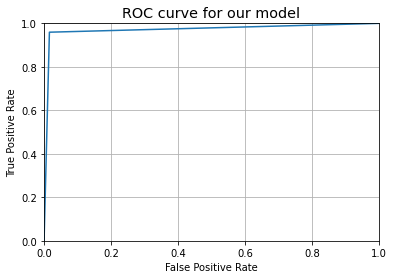

In [25]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

Confusion Matrix without Normalization


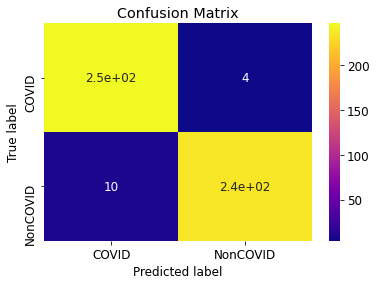

Confusion Matrix with Normalized Values


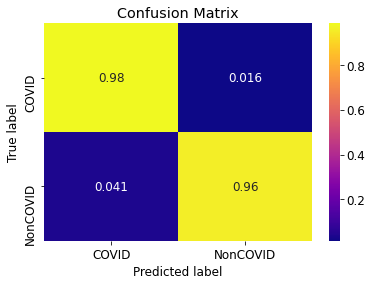

In [26]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

In [27]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin, y_pred_bin))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       251
           1       0.98      0.96      0.97       246

    accuracy                           0.97       497
   macro avg       0.97      0.97      0.97       497
weighted avg       0.97      0.97      0.97       497



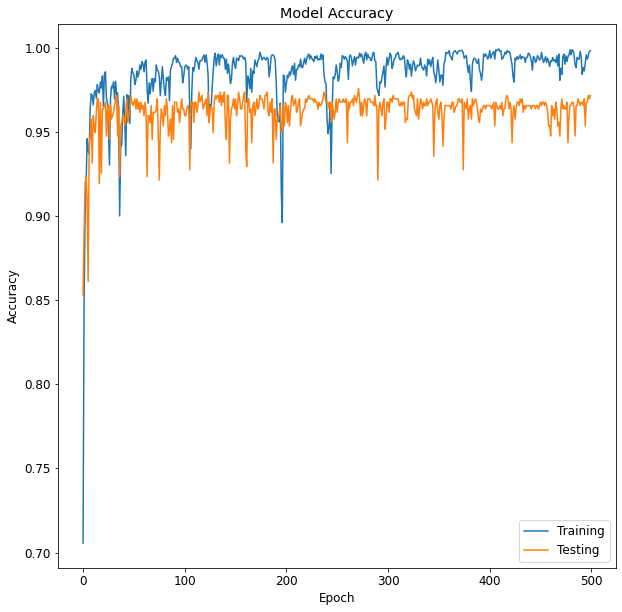

In [28]:
plt.figure(figsize=(10,10))

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
#plt.savefig('mobilenetaug_accuracy.png')
plt.show()

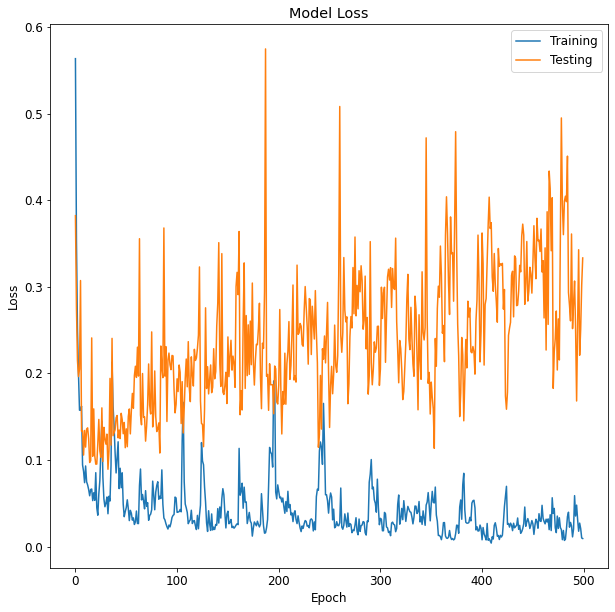

In [29]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
#plt.savefig('inception_ct_loss.png')
plt.show()